# Analyze lists of outliers in the MTT and LDH predictions

In [91]:
# Imports
import polars as pl
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np
import anndata as ad

## Create target sets & define enrichment functions

In [92]:
preds = pl.read_parquet("../../1_snakemake/outputs/cellprofiler/mad_featselect/classifier_results/axiom_continuous_predictions.parquet")
meta = pl.read_parquet("../../1_snakemake/inputs/metadata/metadata.parquet").drop(["Metadata_Compound", "Metadata_Log10Conc"])
pods = pl.read_parquet("../../1_snakemake/outputs/cellprofiler/mad_featselect/curves/pods.parquet")
preds = preds.join(meta, on=["Metadata_Plate", "Metadata_Well"])
preds = preds.join(pods, on="Metadata_Compound", how="left")
preds = preds.with_columns(
    pl.when(pl.col("Metadata_Compound") == "DMSO").then(pl.lit("DMSO")).otherwise(pl.lit("Compound")).alias("Well_type")
)

In [109]:
# Create Motive target set library
targets = pl.read_parquet("../../1_snakemake/inputs/annotations/cg_motive.parquet")
targets = targets.filter(pl.col("interaction_type") == "unknown_direction")
targets = targets.select(["target", "OASIS_ID"]).unique()

target_set_size = targets.select(pl.col("target").value_counts()).unnest("target").filter(pl.col("count") >= 3)
keep_sets = target_set_size.select("target").to_series().to_list()
targets = targets.filter(pl.col("target").is_in(keep_sets))

cmpd_meta = meta.select(["Metadata_OASIS_ID", "Metadata_Perturbation", "Metadata_Well", "Metadata_Plate"]).with_columns(
    pl.concat_str(["Metadata_Perturbation", "Metadata_Well", "Metadata_Plate"], separator="_").alias("Unique_ID")
).drop(["Metadata_Perturbation", "Metadata_Well", "Metadata_Plate"]).rename({"Metadata_OASIS_ID": "OASIS_ID"})

targets = targets.join(cmpd_meta, on="OASIS_ID").select(["target", "Unique_ID"]).unique().rename({"target": "target_set"})

In [94]:
# Create RefChemDB target set library
refchemdb = pl.read_parquet("../../1_snakemake/inputs/annotations/refchemdb_oasis.parquet")
refchemdb = refchemdb.filter(pl.col("support") >= 5).select(["target", "mode", "OASIS_ID"]).unique().with_columns(
    pl.concat_str(["target", "mode"], separator="_").alias("target_set")
)

target_set_size = refchemdb.select(pl.col("target_set").value_counts()).unnest("target_set").filter(pl.col("count") >= 3)
keep_sets = target_set_size.select("target_set").to_series().to_list()
refchemdb = refchemdb.filter(pl.col("target_set").is_in(keep_sets))

refchemdb = refchemdb.join(cmpd_meta, on="OASIS_ID").select(["target_set", "Unique_ID"]).unique()

In [120]:
import polars as pl
from scipy.stats import hypergeom

def overrepresentation_analysis(target_set_library: pl.DataFrame, target_hits: list, universe: list):
    target_hits_set = set(target_hits)
    universe_set = set(universe)
    sets = target_set_library.select(pl.col("target_set")).unique().to_series()
    results = []

    # For each target set, calculate the overlap and perform the hypergeometric test
    for target_set in tqdm(sets):
        targets_in_set = set(target_set_library.filter(pl.col("target_set") == target_set)["Unique_ID"].to_list())
        
        overlap = target_hits_set.intersection(targets_in_set)
        overlap_size = len(overlap)

        M = len(universe_set)  # Total number of genes in the universe
        n = len(targets_in_set)  # Number of genes in the gene set
        N = len(target_hits_set)  # Number of gene hits
        x = overlap_size  # Number of overlapping genes (successes)

        p_value = hypergeom.sf(x - 1, M, n, N)

        results.append({
            "target_set": target_set,
            "overlap_size": overlap_size,
            "target_set_size": n,
            "hit_list_size": N,
            "universe_size": M,
            "p_value": p_value,
            "overlap_hits": ",".join(overlap),
        })

    return pl.DataFrame(results)

# FDR adjust the p-values
def fdr_polars(df: pl.DataFrame):
    p_values = df.select("p_value").to_series().to_numpy()
    _, p_adjusted, _, _ = multipletests(p_values, method='fdr_bh', is_sorted=False)
    df = df.with_columns(pl.Series("fdr", p_adjusted))
    return df

## MTT outlier analysis

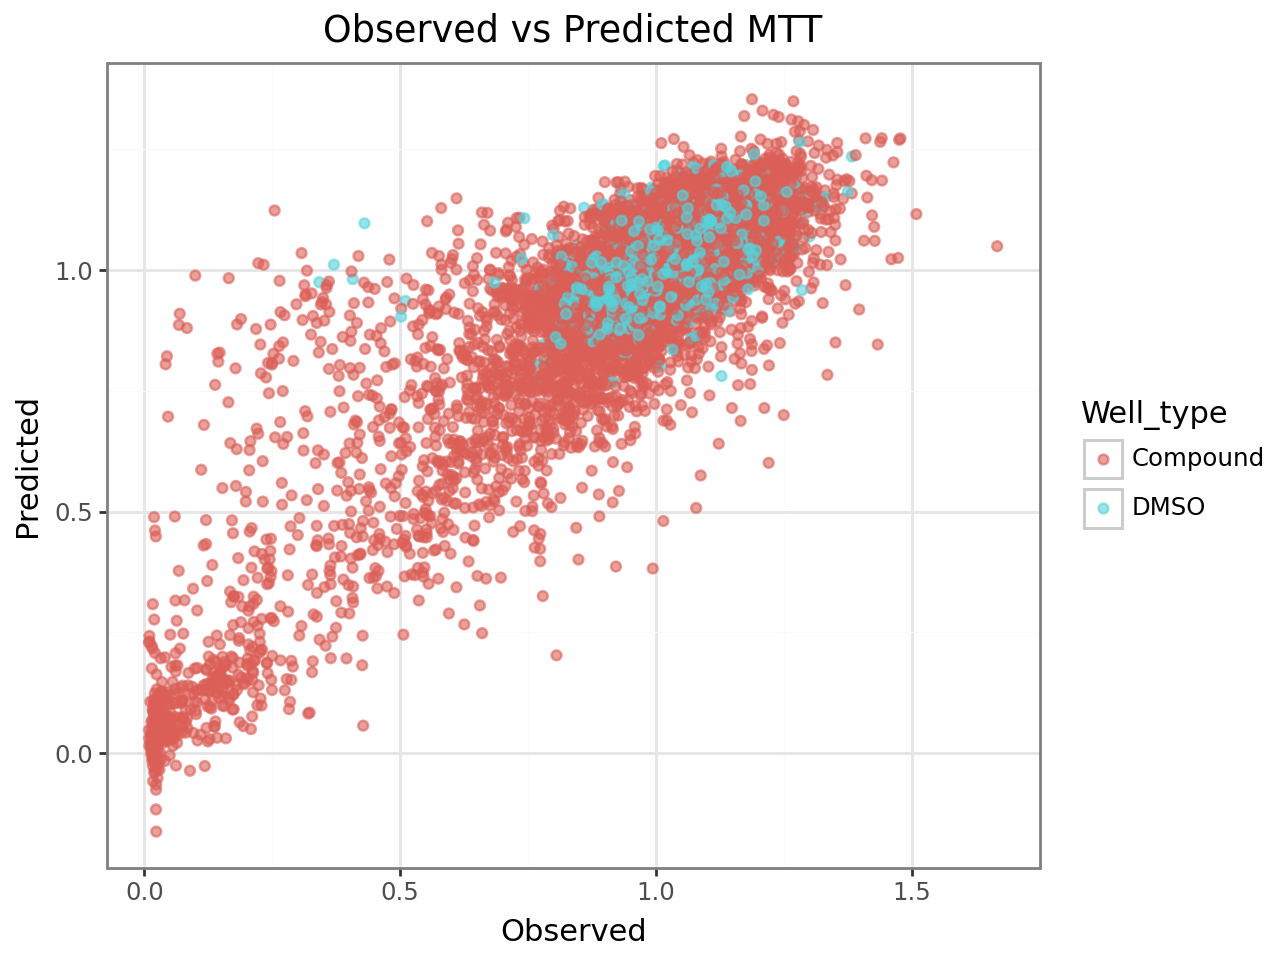

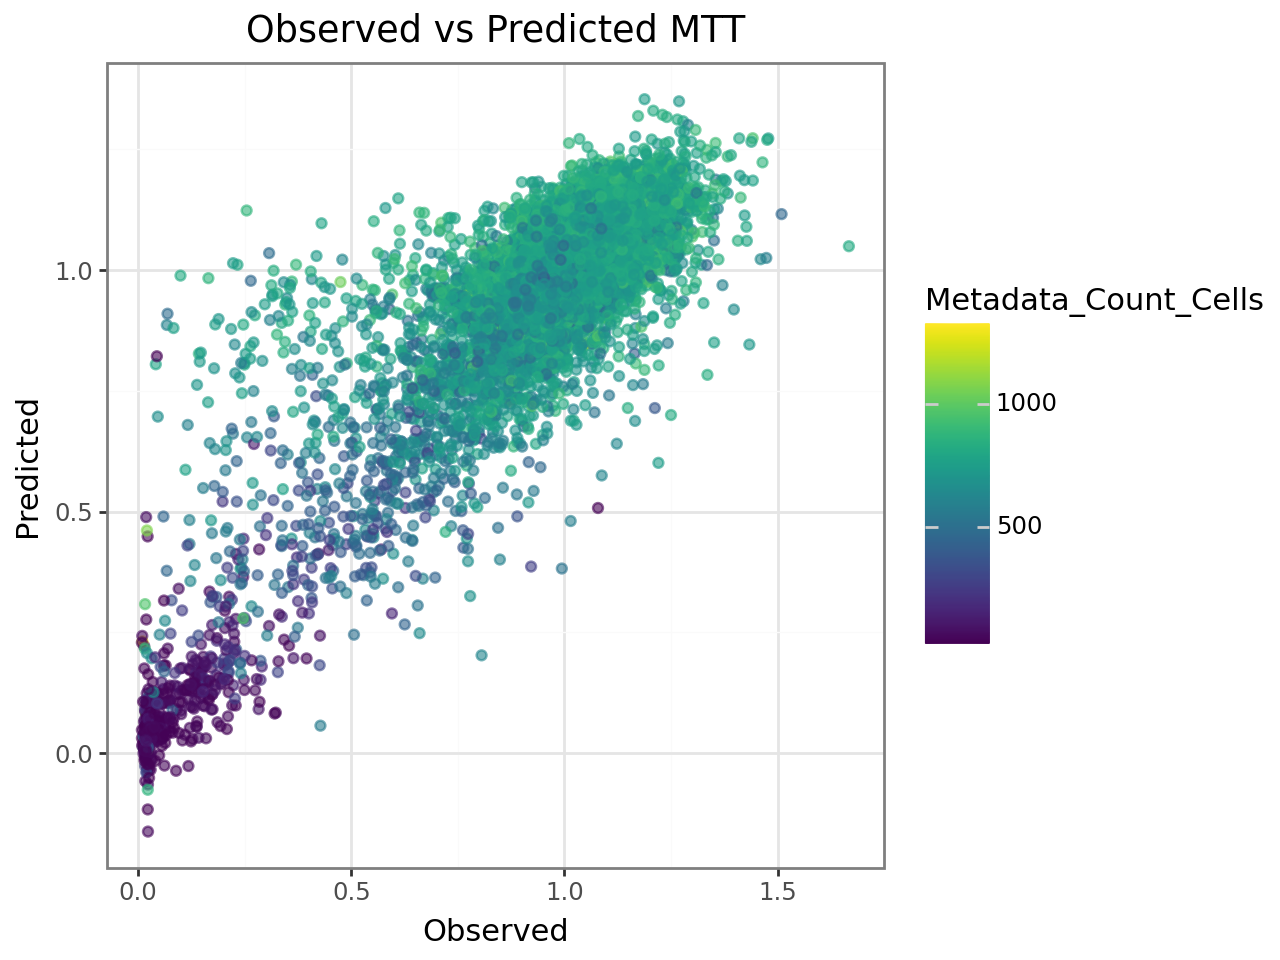

In [6]:
from plotnine import aes, geom_point, ggplot, labs, theme_bw
import plotnine as pn

plot1 = (
    ggplot(preds.filter(pl.col("Variable_Name") == "Metadata_mtt_normalized"), aes(x="Observed", y="Predicted", color="Well_type"))
    + geom_point(alpha=0.6)
    + labs(
        x="Observed",
        y="Predicted",
        title="Observed vs Predicted MTT",
    )
    + theme_bw()
)
plot1.show()

plot1 = (
    ggplot(preds.filter(pl.col("Variable_Name") == "Metadata_mtt_normalized"), aes(x="Observed", y="Predicted", color="Metadata_Count_Cells"))
    + geom_point(alpha=0.6)
    + labs(
        x="Observed",
        y="Predicted",
        title="Observed vs Predicted MTT",
    )
    + theme_bw()
)
plot1.show()

In [98]:
# Get residuals of the 1:1 line
mtt = preds.filter(pl.col("Variable_Name") == "Metadata_mtt_normalized")

mtt = mtt.with_columns(
    (pl.col("Predicted") - pl.col("Observed")).alias("Diff_pred_obs")
)

In [99]:
# Get outliers
std = mtt.select(pl.col("Diff_pred_obs").std()).to_numpy()[0][0]
thresh = std*2.58 # 2.58 std = p-val 0.01

mtt = mtt.with_columns(
    pl.when(pl.col("Diff_pred_obs") > thresh)
      .then(pl.lit("Higher"))
      .when(pl.col("Diff_pred_obs") < (-1*thresh))
      .then(pl.lit("Lower"))
      .otherwise(pl.lit("Normal")).alias("Outlier_flag"),
    pl.concat_str(["Metadata_Perturbation", "Metadata_Well", "Metadata_Plate"], separator="_").alias("Unique_ID"),
)

print(mtt.shape)
mtt.select(pl.col("Outlier_flag").value_counts()).unnest("Outlier_flag")

(21815, 45)


shape: (3, 2)
┌──────────────┬───────┐
│ Outlier_flag ┆ count │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ Lower        ┆ 172   │
│ Higher       ┆ 295   │
│ Normal       ┆ 21348 │
└──────────────┴───────┘

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 230'. Pick better value with 'binwidth'.


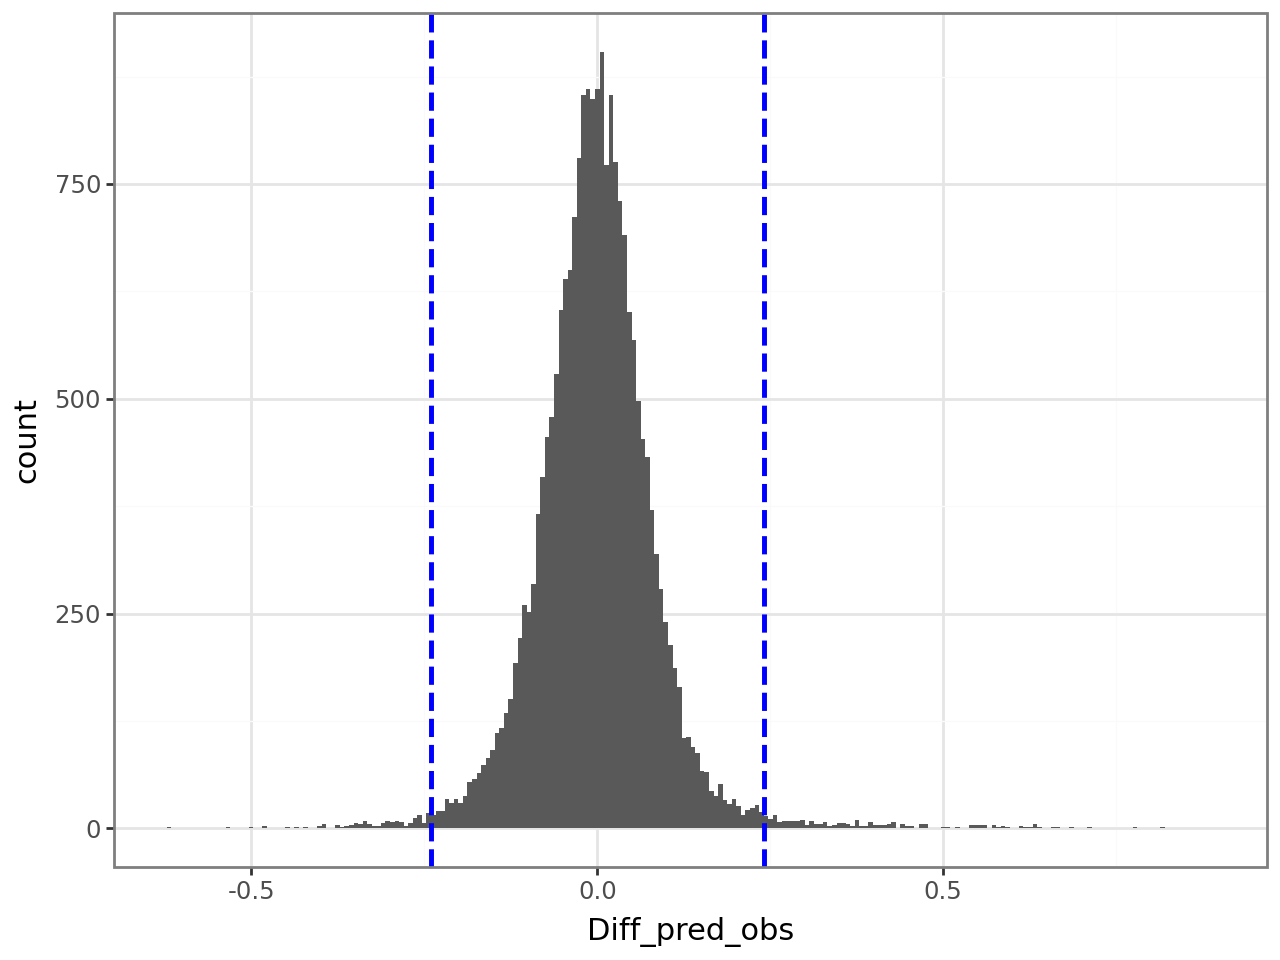

In [9]:
from plotnine import geom_histogram, geom_vline

plot1 = (
    ggplot(mtt, aes(x="Diff_pred_obs"))
    + geom_histogram()
    + geom_vline(xintercept=thresh, color="blue", linetype="dashed", size=1)
    + geom_vline(xintercept=(-thresh), color="blue", linetype="dashed", size=1)
    + labs(
        x="Diff_pred_obs",
    )
    + theme_bw()
)
plot1.show()

In [100]:
# remove DMSO to avoid biasing results
mtt_cmpd = mtt.filter(pl.col("Metadata_Compound") != "DMSO")

higher_mtt = mtt_cmpd.filter(pl.col("Outlier_flag") == "Higher").select("Unique_ID").to_series().to_list()
lower_mtt = mtt_cmpd.filter(pl.col("Outlier_flag") == "Lower").select("Unique_ID").to_series().to_list()

universe_mtt = mtt_cmpd.select("Unique_ID").to_series().unique().to_list()

In [121]:
# Perform overrepresentation analysis
higher_mtt_results = overrepresentation_analysis(targets, higher_mtt, universe_mtt)
lower_mtt_results = overrepresentation_analysis(targets, lower_mtt, universe_mtt)

higher_mtt_results = fdr_polars(higher_mtt_results).sort("fdr")
lower_mtt_results = fdr_polars(lower_mtt_results).sort("fdr")


  0%|          | 0/8858 [00:00<?, ?it/s]

100%|██████████| 8858/8858 [00:15<00:00, 590.28it/s]


In [122]:

higher_mtt_results = higher_mtt_results.select(["target_set", "p_value", "fdr", "overlap_size", "target_set_size", "overlap_hits"]).sort("fdr")
lower_mtt_results = lower_mtt_results.select(["target_set", "p_value", "fdr", "overlap_size", "target_set_size", "overlap_hits"]).sort("fdr")

In [123]:
higher_mtt_results.write_csv("../compiled_results/mtt_higher_targets.csv")
lower_mtt_results.write_csv("../compiled_results/mtt_lower_targets.csv")

## LDH outlier analysis

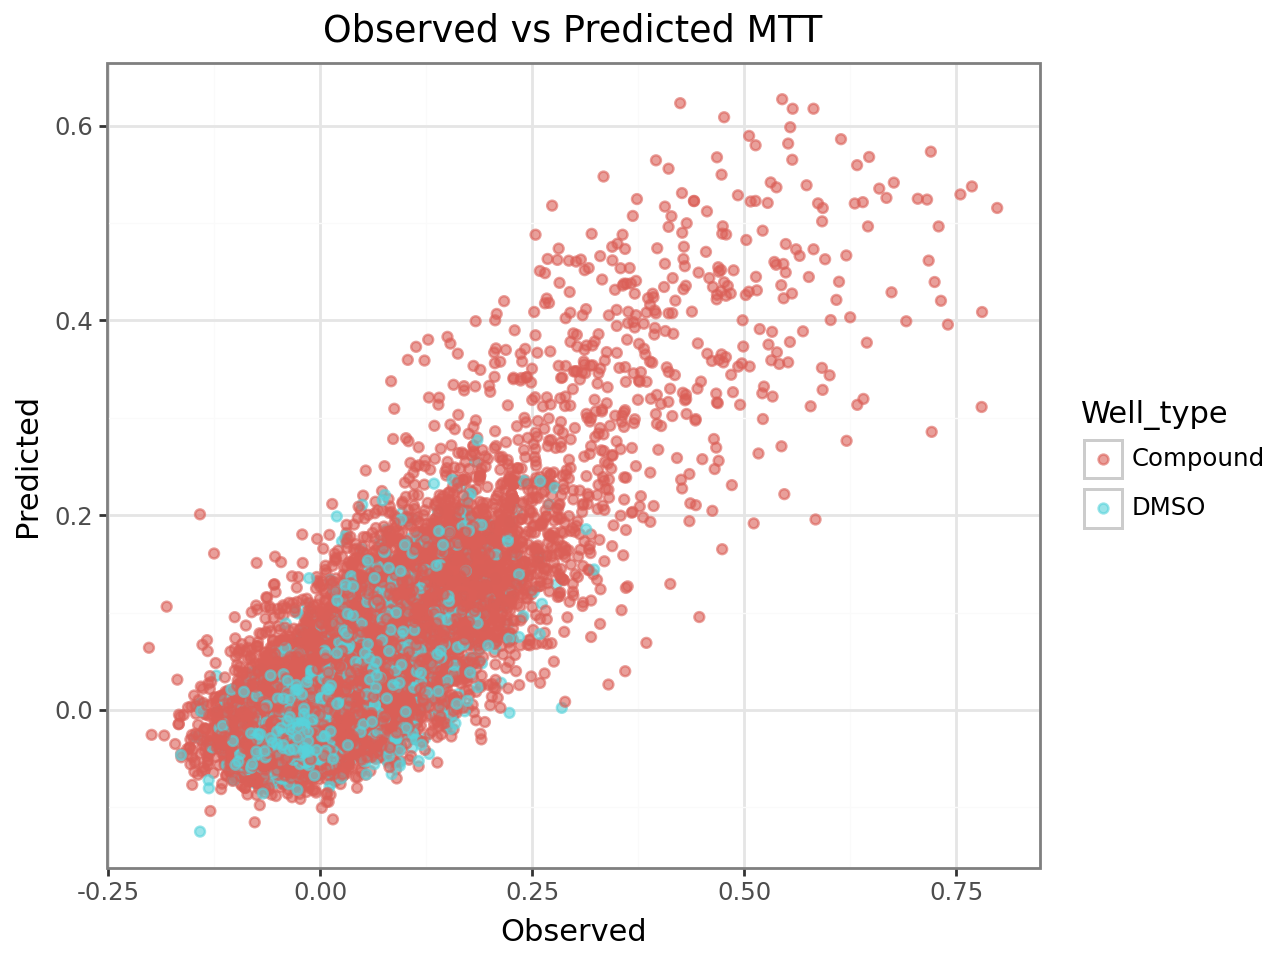

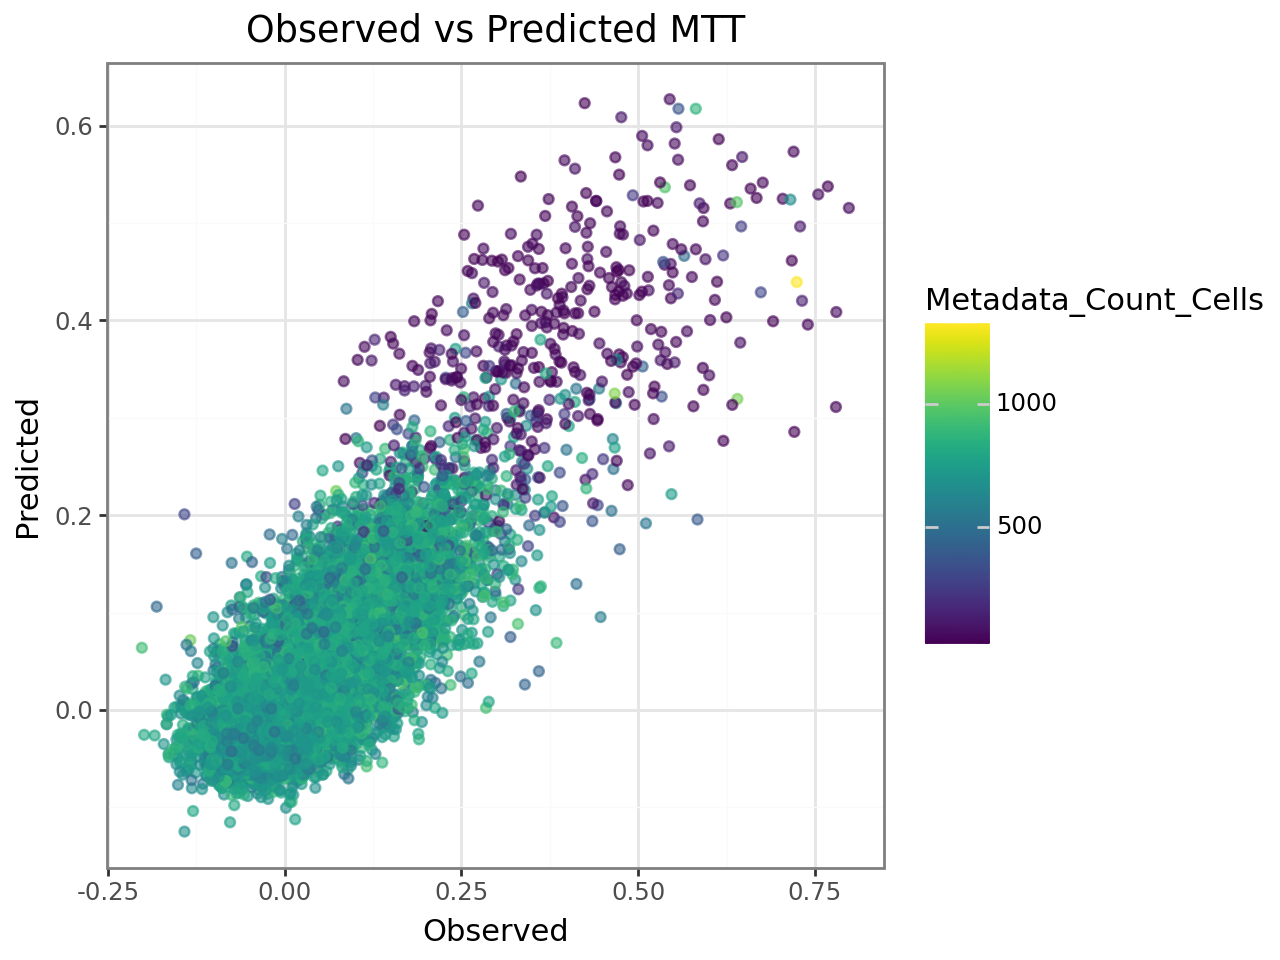

In [12]:
from plotnine import aes, geom_point, ggplot, labs, theme_bw
import plotnine as pn

plot1 = (
    ggplot(preds.filter(pl.col("Variable_Name") == "Metadata_ldh_normalized"), aes(x="Observed", y="Predicted", color="Well_type"))
    + geom_point(alpha=0.6)
    + labs(
        x="Observed",
        y="Predicted",
        title="Observed vs Predicted MTT",
    )
    + theme_bw()
)
plot1.show()

plot1 = (
    ggplot(preds.filter(pl.col("Variable_Name") == "Metadata_ldh_normalized"), aes(x="Observed", y="Predicted", color="Metadata_Count_Cells"))
    + geom_point(alpha=0.6)
    + labs(
        x="Observed",
        y="Predicted",
        title="Observed vs Predicted MTT",
    )
    + theme_bw()
)
plot1.show()

In [102]:
# Get residuals of the 1:1 line
ldh = preds.filter(pl.col("Variable_Name") == "Metadata_ldh_normalized")

ldh = ldh.with_columns(
    (pl.col("Predicted") - pl.col("Observed")).alias("Diff_pred_obs")
)

In [103]:
# Get outliers
std = ldh.select(pl.col("Diff_pred_obs").std()).to_numpy()[0][0]
thresh = std*2.58 # 2.58 std = p-val 0.01

ldh = ldh.with_columns(
    pl.when(pl.col("Diff_pred_obs") > thresh)
      .then(pl.lit("Higher"))
      .when(pl.col("Diff_pred_obs") < (-1*thresh))
      .then(pl.lit("Lower"))
      .otherwise(pl.lit("Normal")).alias("Outlier_flag"),
    pl.concat_str(["Metadata_Perturbation", "Metadata_Well", "Metadata_Plate"], separator="_").alias("Unique_ID"),
)

print(ldh.shape)
ldh.select(pl.col("Outlier_flag").value_counts()).unnest("Outlier_flag")

(21807, 45)


shape: (3, 2)
┌──────────────┬───────┐
│ Outlier_flag ┆ count │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ Higher       ┆ 172   │
│ Lower        ┆ 282   │
│ Normal       ┆ 21353 │
└──────────────┴───────┘

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 181'. Pick better value with 'binwidth'.


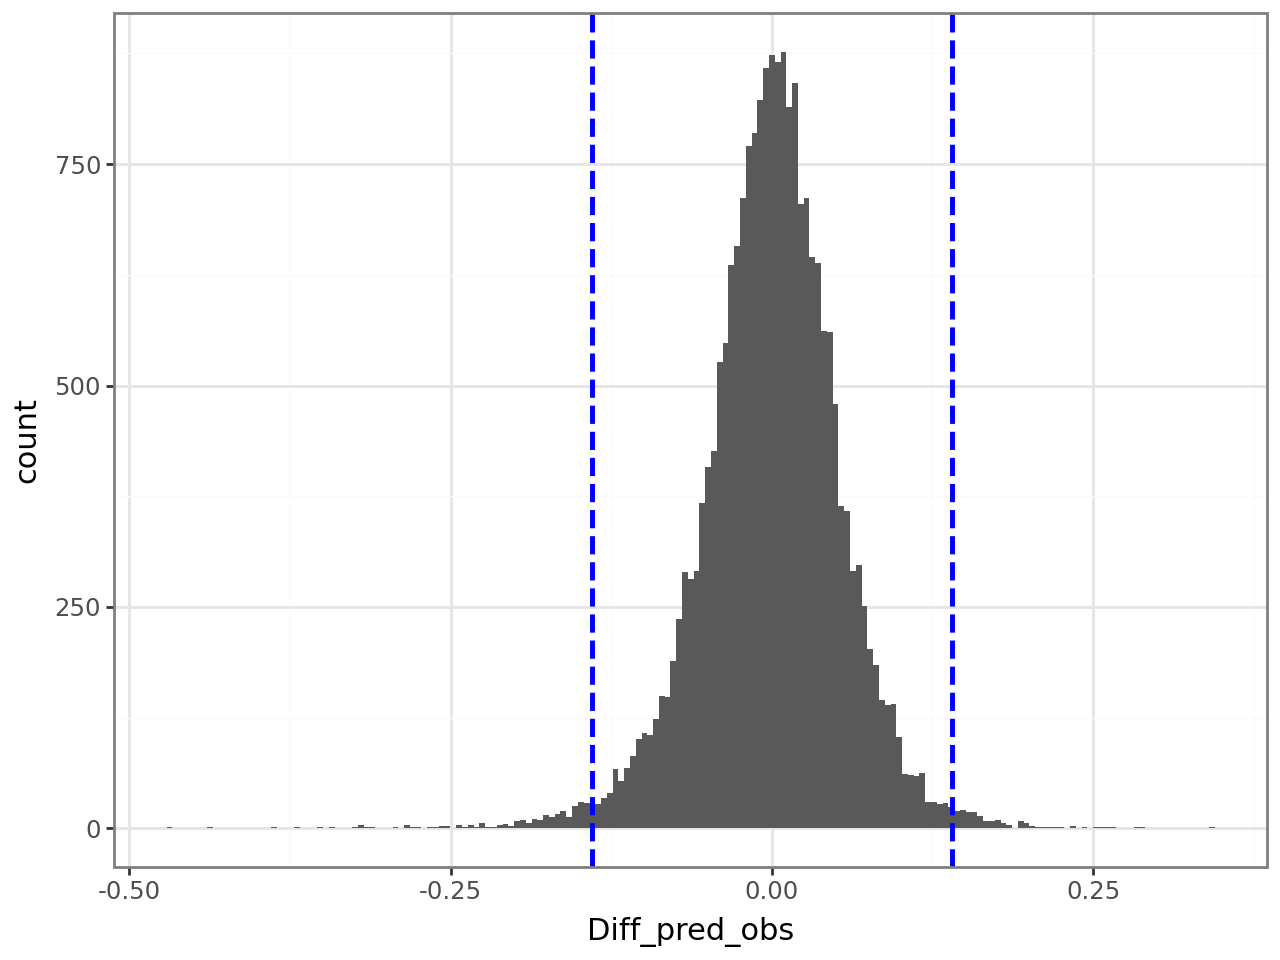

In [15]:
from plotnine import geom_histogram, geom_vline

plot1 = (
    ggplot(ldh, aes(x="Diff_pred_obs"))
    + geom_histogram()
    + geom_vline(xintercept=thresh, color="blue", linetype="dashed", size=1)
    + geom_vline(xintercept=(-thresh), color="blue", linetype="dashed", size=1)
    + labs(
        x="Diff_pred_obs",
    )
    + theme_bw()
)
plot1.show()

In [104]:
# remove DMSO to avoid biasing results
ldh_cmpd = ldh.filter(pl.col("Metadata_Compound") != "DMSO")

higher_ldh = ldh_cmpd.filter(pl.col("Outlier_flag") == "Higher").select("Unique_ID").to_series().to_list()
lower_ldh = ldh_cmpd.filter(pl.col("Outlier_flag") == "Lower").select("Unique_ID").to_series().to_list()

universe_ldh = ldh_cmpd.select("Unique_ID").to_series().unique().to_list()

In [111]:
# Perform overrepresentation analysis
higher_ldh_results = overrepresentation_analysis(targets, higher_ldh, universe_ldh)
lower_ldh_results = overrepresentation_analysis(targets, lower_ldh, universe_ldh)

higher_ldh_results = fdr_polars(higher_ldh_results)
lower_ldh_results = fdr_polars(lower_ldh_results)

higher_ldh_results = higher_ldh_results.select(["target_set", "fdr", "overlap_size", "target_set_size"]).sort("fdr")
lower_ldh_results = lower_ldh_results.select(["target_set", "fdr", "overlap_size", "target_set_size"]).sort("fdr")

  0%|          | 0/8858 [00:00<?, ?it/s]

100%|██████████| 8858/8858 [00:16<00:00, 546.57it/s]


In [41]:
keep_cols = ["Metadata_Compound", "Metadata_Plate", "Metadata_Well", "Metadata_source", "Outlier_flag", "Diff_pred_obs"]

plot_mtt = mtt.select(keep_cols).filter(pl.col("Outlier_flag") == "Higher").sort(pl.col("Diff_pred_obs"), descending=True)
plot_dmso = mtt.select(keep_cols).filter(pl.col("Outlier_flag") == "Normal").filter(pl.col("Metadata_Compound") == "DMSO").sample(n=plot_mtt.shape[0], seed=42)

plot_samples = pl.concat([plot_mtt, plot_dmso], how="vertical").with_columns(
    pl.concat_str(["Metadata_Plate", "Metadata_Well"], separator="_").alias("Metadata_well_id")
).select("Metadata_well_id").to_series().to_list()

## Cluster samples

In [54]:
profiles = pl.read_parquet("/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/profiles/mad_featselect.parquet").with_columns(
    pl.concat_str(["Metadata_Plate", "Metadata_Well"], separator="_").alias("Metadata_well_id")
)

profiles = profiles.filter(pl.col("Metadata_well_id").is_in(plot_samples))

profiles = profiles.with_columns(
    pl.when(pl.col("Metadata_Compound") == "DMSO").then(pl.lit("DMSO")).otherwise(pl.lit("Exposure")).alias("Metadata_exposure_type")
)


In [55]:
meta_cols = [i for i in profiles.columns if "Metadata" in i]
feat_cols = [i for i in profiles.columns if "Metadata" not in i]

metadata_df = profiles.select(meta_cols).to_pandas()
numerical_df = profiles.select(feat_cols).to_pandas()

adata = ad.AnnData(
    X=numerical_df.values,  # Expression matrix as a NumPy array
    obs=metadata_df.set_index("Metadata_well_id"),  # Metadata with cell_id as index
    var=pd.DataFrame(index=feat_cols)  # Feature names as index
)

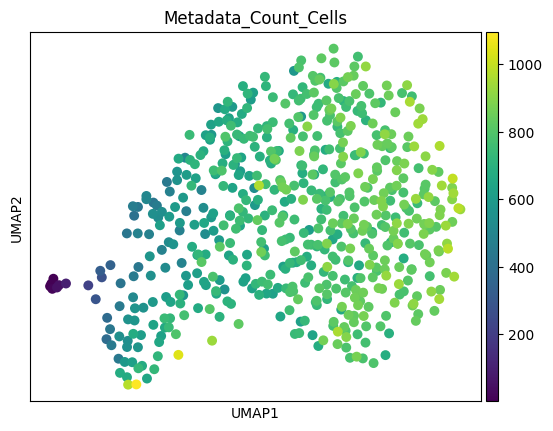

In [86]:
import scanpy as sc

sc.pp.neighbors(adata, n_neighbors=10, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color='Metadata_Count_Cells')

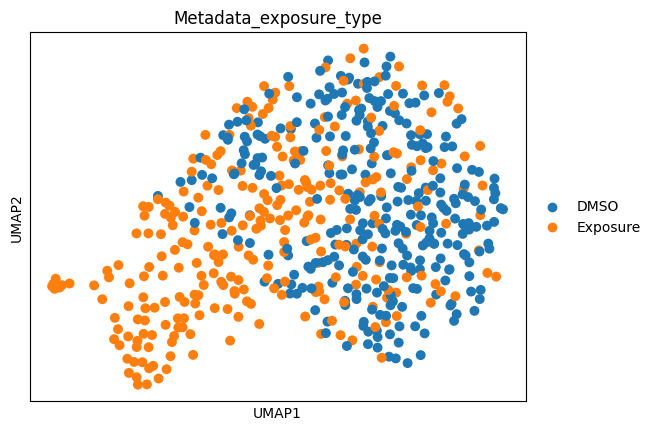

In [87]:
sc.pl.umap(adata, color='Metadata_exposure_type')

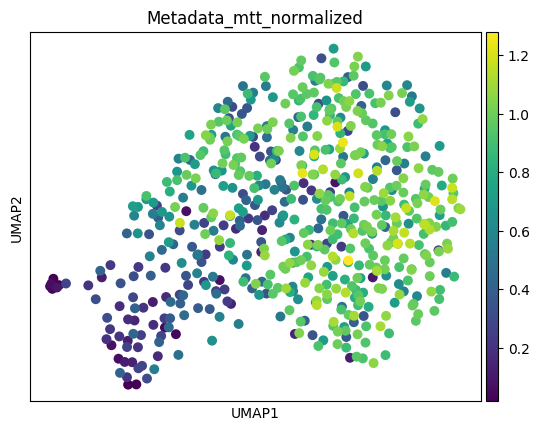

In [88]:
sc.pl.umap(adata, color='Metadata_mtt_normalized')

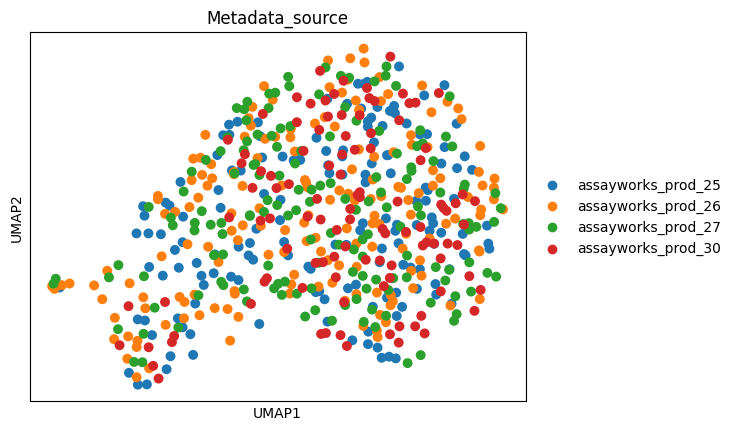

In [90]:
sc.pl.umap(adata, color='Metadata_source')

In [78]:
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt

distance_matrix = squareform(pdist(adata.X, metric='euclidean'))
cosine_distance_matrix = squareform(pdist(adata.X, metric='cosine')) 
cosine_similarity_matrix = 1 - cosine_distance_matrix

metadata = adata.obs.reset_index()['Metadata_exposure_type']
metadata_colors = pd.Categorical(metadata).codes

unique_categories = metadata.unique()
palette = sns.color_palette("tab10", len(unique_categories))
metadata_color_map = dict(zip(unique_categories, palette))


/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


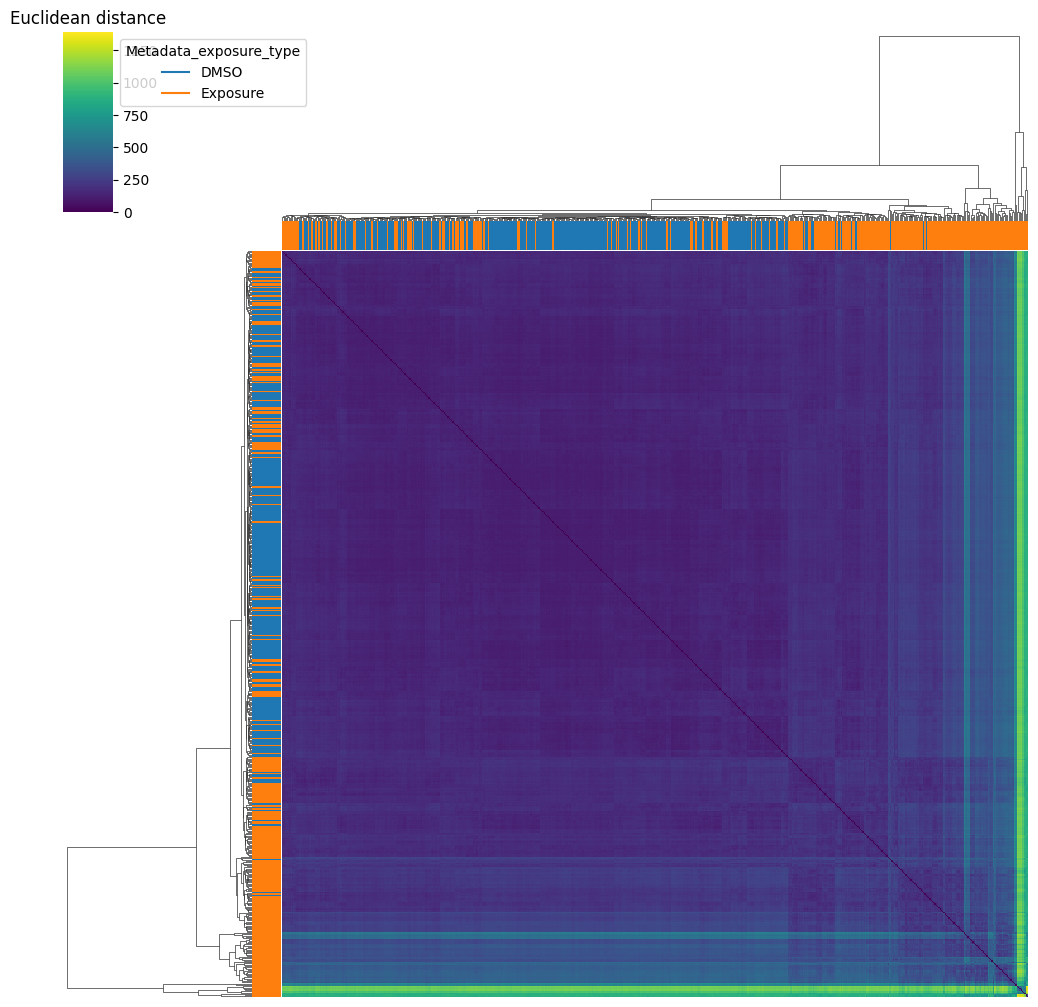

In [79]:
metadata = metadata.reset_index(drop=True)
metadata = metadata.astype(str)
row_colors = metadata.map(metadata_color_map).to_numpy()


sns.clustermap(
    distance_matrix,
    cmap='viridis',
    xticklabels=False,
    yticklabels=False,
    row_colors=row_colors,
    col_colors=row_colors,
    figsize=(10, 10)
)

for category, color in metadata_color_map.items():
    plt.plot([], [], color=color, label=category)
plt.legend(title="Metadata_exposure_type", bbox_to_anchor=(1, 1), loc='upper left')
plt.title("Euclidean distance")
plt.show()

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


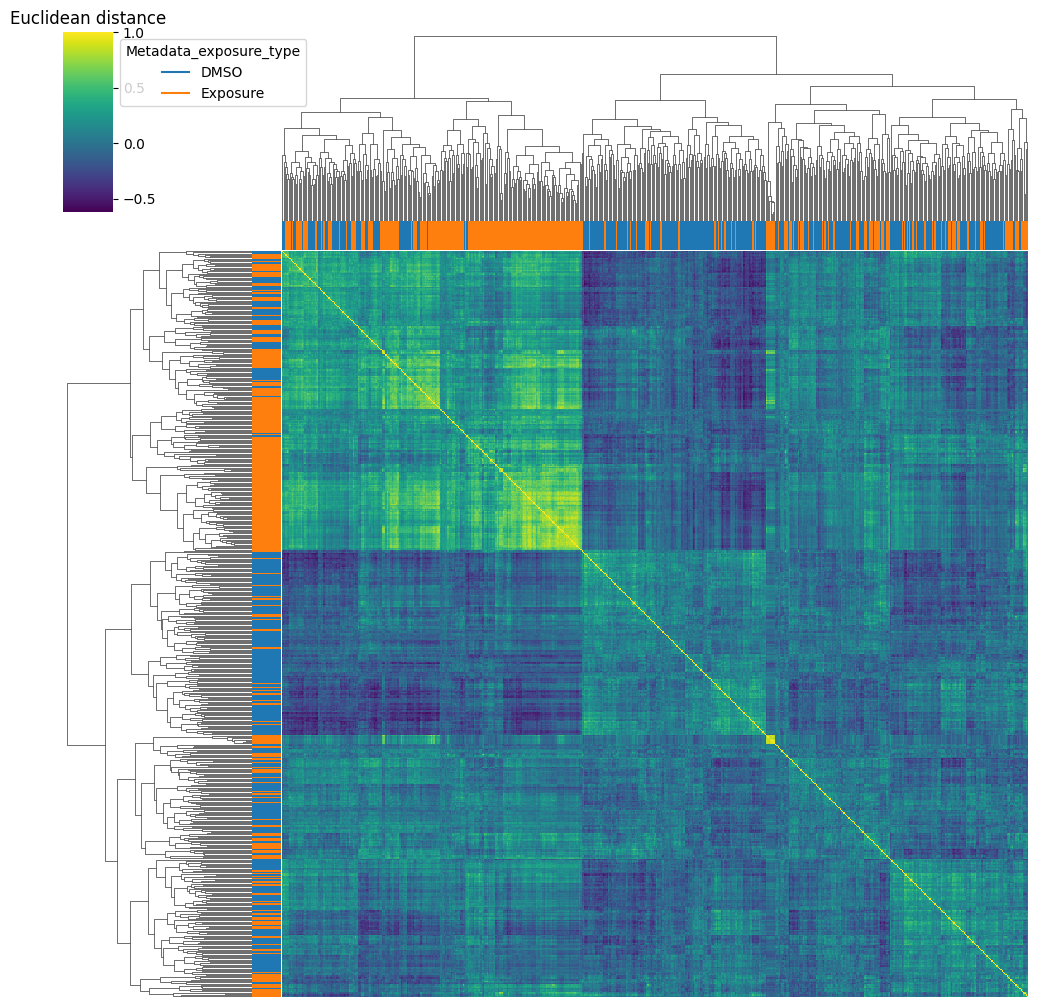

In [80]:
sns.clustermap(
    cosine_similarity_matrix,
    cmap='viridis',
    xticklabels=False,
    yticklabels=False,
    row_colors=row_colors,
    col_colors=row_colors,
    figsize=(10, 10)
)

for category, color in metadata_color_map.items():
    plt.plot([], [], color=color, label=category)
plt.legend(title="Metadata_exposure_type", bbox_to_anchor=(1, 1), loc='upper left')
plt.title("Euclidean distance")
plt.show()